Using device: mps
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Generator(
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=12544, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slo

FileNotFoundError: [Errno 2] No such file or directory: 'gan_image/v1_0/gan_generated_image_epoch_1.png'

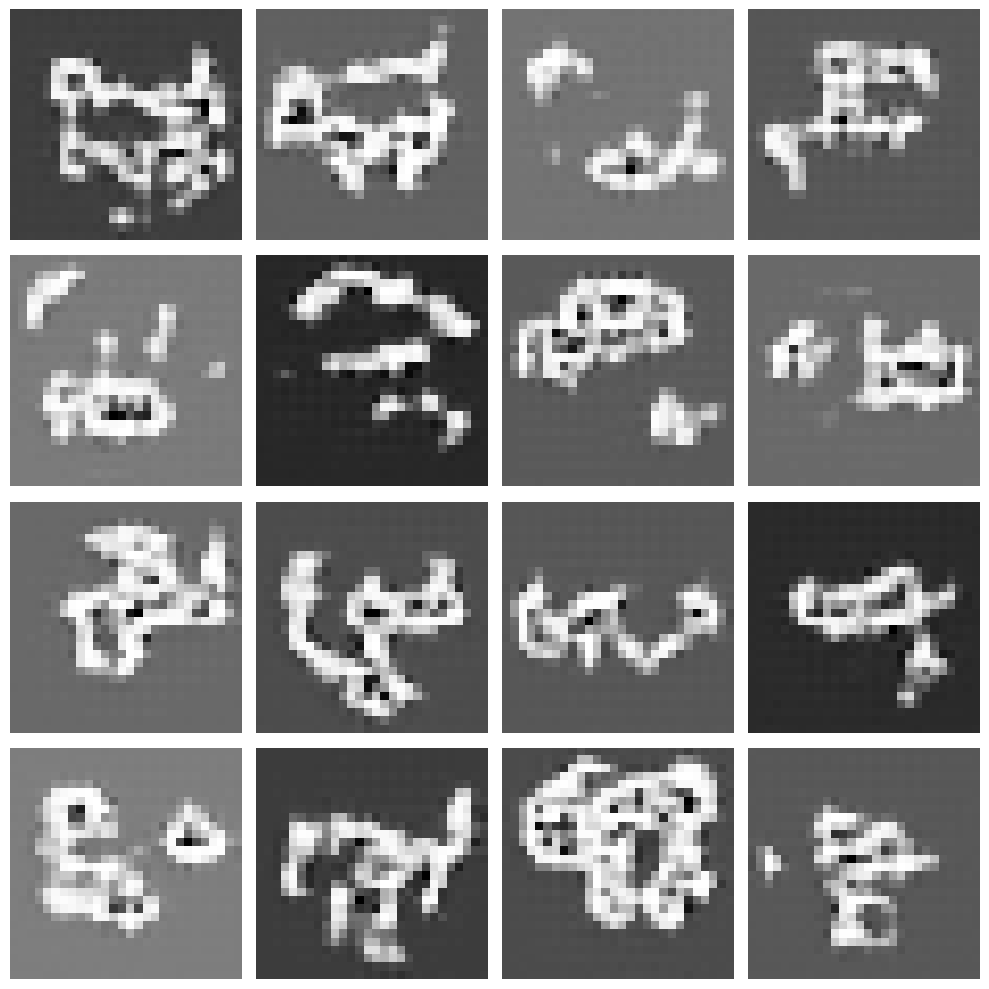

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import urllib.request
from tqdm import tqdm

# --- Constants ---
IMAGE_SIZE = 28
CHANNELS = 1
BATCH_SIZE = 64
LATENT_DIM = 128
LATENT_DIM_GAN = 128
EPOCHS = 2000
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']
DATA_DIR = "quickdraw_data"
MAX_ITEMS_PER_CLASS = 100000

# --- Ensure Reproducibility ---
torch.manual_seed(42)
np.random.seed(42)

# --- Device Configuration ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Clear GPU memory if using MPS
if device == torch.device("mps"):
    torch.mps.empty_cache()

# --- Data Loading and Preparation ---
def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    os.makedirs(DATA_DIR, exist_ok=True)
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, 
                                         reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            print("Please ensure the data has been downloaded correctly.")
            return None, None

    return np.concatenate(all_data), np.concatenate(all_labels)

# Download and load data
download_quickdraw_data(CLASSES)
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

# Skip if data loading failed
if x_data is None or labels is None:
    print("Data loading failed. Please check previous steps.")
else:
    # Reshape and normalize data
    x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.

    # Split into training and testing sets
    num_samples = len(x_data)
    train_size = int(0.8 * num_samples)
    x_train, x_test = x_data[:train_size], x_data[train_size:]
    y_train, y_test = labels[:train_size], labels[train_size:]

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    x_test = torch.from_numpy(x_test).float()
    y_train = torch.from_numpy(y_train).long()
    y_test = torch.from_numpy(y_test).long()

    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

# --- Improved GAN Model (PyTorch) ---
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 256),
            nn.LeakyReLU(0.2)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 256, 7, 7)
        img = self.conv_layers(x)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Create generator and discriminator instances and move them to device
improved_generator = Generator(latent_dim=LATENT_DIM_GAN).to(device)
improved_discriminator = Discriminator().to(device)

# Print model summaries
print(improved_generator)
print(improved_discriminator)

# Optimizers
optimizer_G = optim.Adam(improved_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(improved_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss Function
criterion = nn.BCELoss()

# Function to generate and save images
def generate_and_save_images(generator, epoch, latent_dim, examples=16, dim=(4, 4), figsize=(10, 10)):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(examples, latent_dim, device=device)
        generated_images = generator(noise).cpu()
        generated_images = 0.5 * generated_images + 0.5

        fig = plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i, 0, :, :], cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'gan_image/v1_0/gan_generated_image_epoch_{epoch}.png')
        plt.close(fig)
    generator.train()

# Training Loop
start_time = time.time()
d_losses = []
g_losses = []

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    epoch_d_losses = []
    epoch_g_losses = []

    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        outputs_real = improved_discriminator(real_images)
        d_loss_real = criterion(outputs_real, real_labels)

        noise = torch.randn(batch_size, LATENT_DIM_GAN, device=device)
        fake_images = improved_generator(noise)
        outputs_fake = improved_discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        misleading_labels = torch.ones(batch_size, 1, device=device)
        outputs = improved_discriminator(fake_images)
        g_loss = criterion(outputs, misleading_labels)
        g_loss.backward()
        optimizer_G.step()

        # Store batch losses
        epoch_d_losses.append(d_loss.item())
        epoch_g_losses.append(g_loss.item())

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Batch {batch_idx}/{len(train_loader)} "
                  f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    # Calculate and store average losses
    avg_d_loss = sum(epoch_d_losses) / len(epoch_d_losses)
    avg_g_loss = sum(epoch_g_losses) / len(epoch_g_losses)
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - "
          f"D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}, "
          f"Time: {time.time() - epoch_start_time:.2f}s")

    # Generate and save images
    generate_and_save_images(improved_generator, epoch + 1, LATENT_DIM_GAN)

    # Clear MPS memory after each epoch
    if device == torch.device("mps"):
        torch.mps.empty_cache()

# Save models
torch.save(improved_generator.state_dict(), "improved_gan_generator.pth")
torch.save(improved_discriminator.state_dict(), "improved_gan_discriminator.pth")
print("Models saved successfully.")

torch.save(improved_generator.state_dict(), "improved_gan_generator.h5")
print("Improved GAN generator saved as improved_gan_generator.h5")

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

print(f"Total training time: {time.time() - start_time:.2f} seconds")


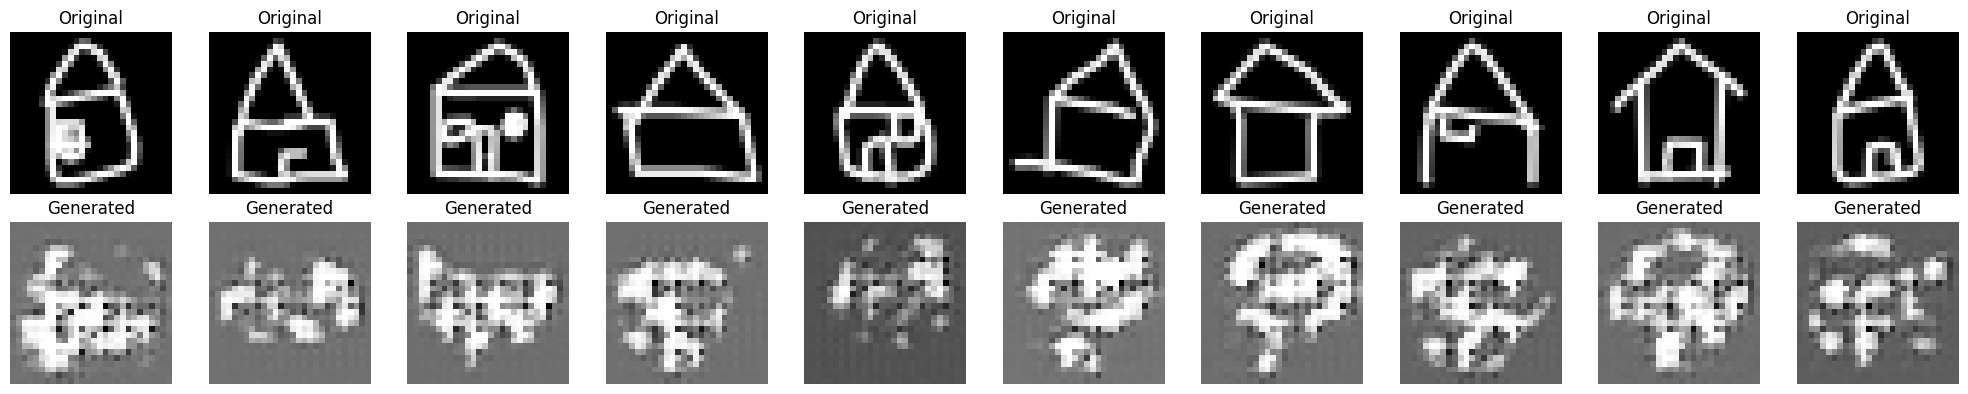

In [4]:
import matplotlib.pyplot as plt

def generate_and_compare_images(generator, dataloader, n=10, latent_dim=LATENT_DIM_GAN):
    """Generates new images and compares them to real images."""

    # Get a batch of real images from the dataloader
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:n].to(device)  # Move to the correct device (CPU or GPU)

    # Generate corresponding fake images
    with torch.no_grad():
        noise = torch.randn(n, latent_dim, device=device)
        generated_images = generator(noise).detach().cpu()

    # Rescale images from [-1, 1] to [0, 1] if necessary (for tanh output)
    generated_images = 0.5 * generated_images + 0.5

    # Plot the images
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20, 4))  # 2 rows: original and generated

    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(real_images[i].cpu().squeeze(), cmap='gray')  # Move to CPU before plotting
        plt.title("Original")
        plt.axis("off")

        # Generated images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.title("Generated")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage (assuming you have your test_loader defined):
generate_and_compare_images(improved_generator, test_loader, n=10)